In [1]:
%matplotlib inline
%pylab inline

import menpo.io as mio
from menpo.feature import no_op, fast_dsift
from menpo.landmark import labeller, ibug_face_66
from menpo.visualize import visualize_images
from menpo.image import Image

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Define MCCF patch expert

Start by defining `centralize` and `normalize_norm` feature functions:

In [2]:
from menpo.feature import ndfeature

@ndfeature
def centralize(x, channels=True):
    if channels:
        m = np.mean(x, axis=(-2, -1))[..., None, None]
    else:
        m = np.mean(x)
    
    x = x - m
    
    return x


@ndfeature
def normalize_norm(x, channels=True):
    x = centralize(x, channels=channels)
    
    if channels:
        norm = np.asarray(np.linalg.norm(x, axis=(-2, -1))[..., None, None])
    else:
        norm = np.asarray(np.linalg.norm(x))
        
    if np.any(norm == 0):
        raise ValueError("Image has 0 variance - can't be normalized")
    else:
        x = x / norm
    
    return x

Multi-Channel Correlation Filters (MCCF) patch expert:

In [3]:
from pyfftw.interfaces.numpy_fft import fft2, fftshift
from menpo.image import Image
from menpofit.math.correlationfilter import mccf
from menpofit.math.fft_utils import fft_convolve2d_sum

class MCCFPatchExpert(object):
    r"""
    Multi-Channel Correlation Filter patch expert
    """
    def __init__(self, l=1, normalize_callable=normalize_norm,
                 cosine_mask=True, boundary='constant'):
        self.l = l
        self.normalize_callable = normalize_callable
        self.cosine_mask = cosine_mask
        self.boundary = boundary

    def train(self, X, t):
        # number of samples, number of channels, height and width
        n, k, h, w = X.shape

        if self.cosine_mask:
            # compute cosine mask if required
            cy = np.hanning(h)
            cx = np.hanning(w)
            self.cosine_mask = cy[..., None].dot(cx[None, ...])

        # for each sample
        keep = []
        count = 0
        for j, x in enumerate(X):
            try:
                # normalize it if required
                x = self.normalize_callable(x)
                # apply cosine mask if required
                if self.cosine_mask is not None:
                    x = self.cosine_mask * x
                X[count] = x
                keep.append(j)
                count += 1
            except:
                pass
            
        X = X[:count]

        # compute correlation filter
        self.filter = mccf(X, t, l=self.l, boundary=self.boundary)[0]
        self.rescaled_filter = Image(self.filter).rescale(0.5).pixels
        
        return self

    @property
    def spatial_filter_image(self):
        return Image(self.filter[:, ::-1, ::-1])

    @property
    def frequency_filter_image(self):
        return Image(np.abs(fftshift(fft2(self.filter[:, ::-1, ::-1]))))
    
    def predict(self, x):
        # normalize if required
        x = self.normalize_callable(x)
        # compute filter response
        return fft_convolve2d_sum(x, self.filter)

## Load images

In [4]:
images = []
for i in mio.import_images('/Users/joan/PhD/DataBases/faces/lfpw/trainset/', 
                           verbose=True, max_images=100):
    if i.n_channels == 3:
        i = i.crop_to_landmarks_proportion(0.8)
        i = i.rescale_landmarks_to_diagonal_range(200)
        labeller(i, 'PTS', ibug_face_66)
        images.append(i)

Importing assets: [==========] 100% (100/100) - done.                           


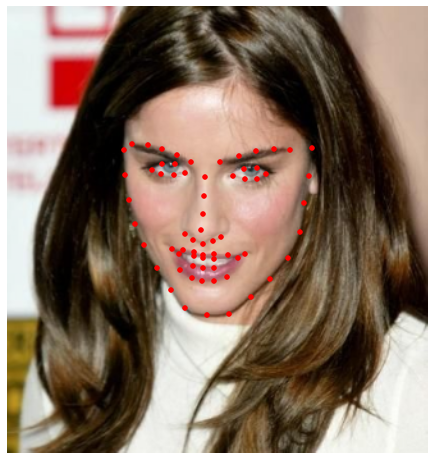

In [5]:
visualize_images(images)

In [6]:
shapes = [i.landmarks['ibug_face_66'].lms for i in images]

## Train a MCCF patch expert

In [34]:
from scipy.stats import multivariate_normal
from menpo.shape import PointCloud
from menpofit.base import build_grid
from menpofit.clm.patch_experts import check_context_size

patch_size = (32, 32) 
context_size= 2
covariance = 5
landmark = 42

# check parameters
context_size = check_context_size(context_size, patch_size)

# build desired response
grid = build_grid(patch_size)
response = np.swapaxes(grid, 2, 0)[0:1]
#response = multivariate_normal(mean=np.zeros(2), cov=covariance).pdf(grid)

samples = []
for (i, s) in zip(images, shapes):
    # choose appropriate landmark
    centre = PointCloud([s.points[landmark]])
    # extract positive sample
    p = i.extract_patches(centre, patch_size=context_size,
                          as_single_array=True)[0, 0]

    # add positive sample to list
    samples.append(p)

# turn list into ndarray
samples = np.asarray(samples)
# train patch experts
patch_expert = MCCFPatchExpert(l=10).train(samples, response)

In [35]:
from scipy.stats import multivariate_normal
from menpo.shape import PointCloud
from menpofit.base import build_grid
from menpofit.clm.patch_experts import check_context_size

# check parameters
context_size = check_context_size(context_size, patch_size)

# build desired response
grid = build_grid(patch_size)
response = np.swapaxes(grid, 2, 0)[1:2]
#response = multivariate_normal(mean=np.zeros(2), cov=covariance).pdf(grid)

samples = []
for (i, s) in zip(images, shapes):
    # choose appropriate landmark
    centre = PointCloud([s.points[landmark]])
    # extract positive sample
    p = i.extract_patches(centre, patch_size=context_size,
                          as_single_array=True)[0, 0]

    # add positive sample to list
    samples.append(p)

# turn list into ndarray
samples = np.asarray(samples)
# train patch experts
patch_expert2 = MCCFPatchExpert(l=10).train(samples, response)

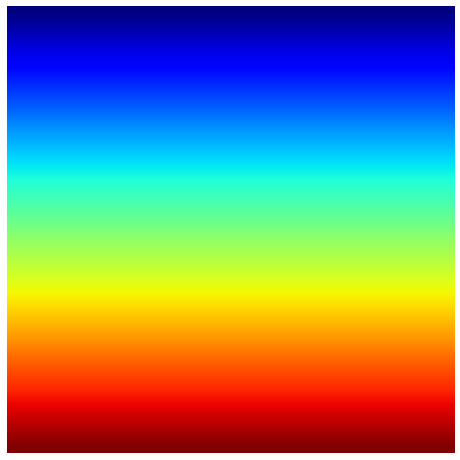

In [36]:
Image(grid[..., 0]).view(cmap_name='jet')

Visualize ideal response:

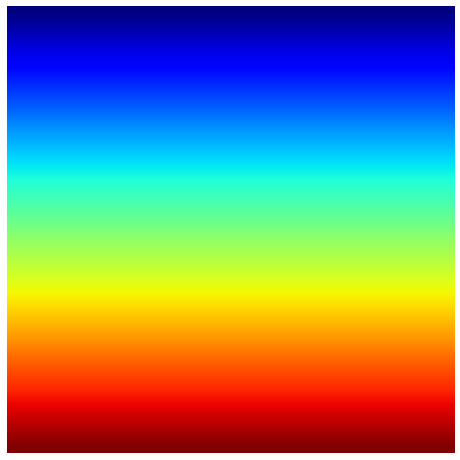

In [37]:
Image(response).view(cmap_name='jet')

Visualize samples:

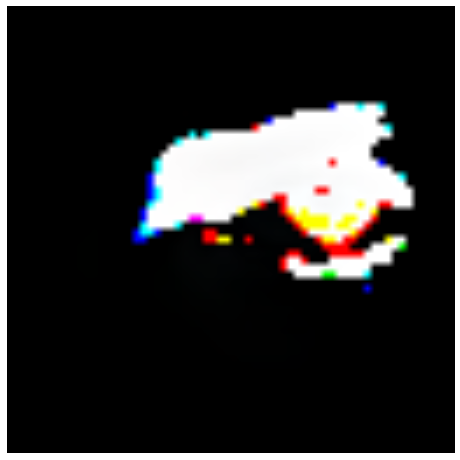

In [38]:
samples_images = [Image(s) for s in samples]

visualize_images(samples_images)

Visualize filters:

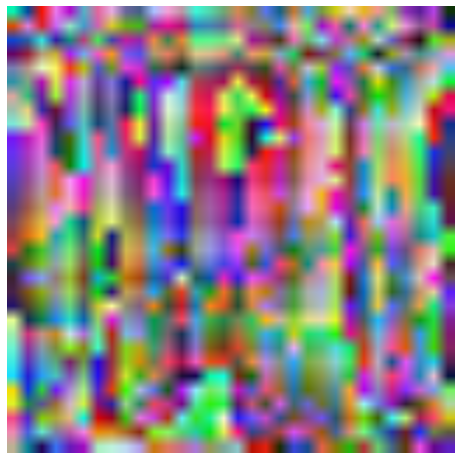

In [39]:
patch_expert.spatial_filter_image.view_widget()

Visualize response on training patches:

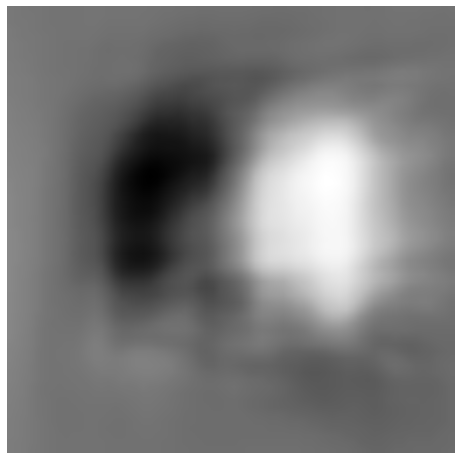

In [40]:
response_maps = [patch_expert.predict(Image(s)) for s in samples]

visualize_images(response_maps)

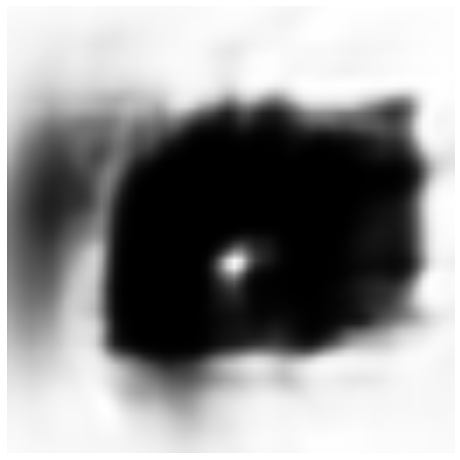

In [43]:
response_maps = []
for s in samples:
    a = np.empty((64, 64, 2))
    a[..., 0] = patch_expert.predict(s)
    a[..., 1] = patch_expert2.predict(s)
    rm = multivariate_normal(mean=np.zeros(2), cov=10).pdf(a)
    response_maps.append(Image(rm))

visualize_images(response_maps)

In [ ]:
response_maps[1].pixels

Visualize responses on entire training images:

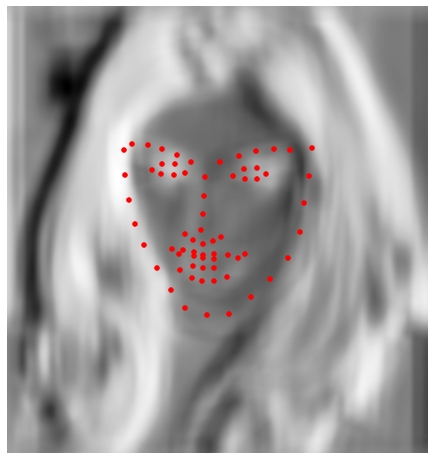

In [45]:
response_maps = [patch_expert.predict(i) for i in images]

visualize_images(response_maps)